In [1]:
import matplotlib.pyplot as plot
import os
import math
import time
import numpy as np
import torch
import torch.optim
import torch.nn as nn

In [2]:
#Define the network
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                                padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                                padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
            out = self.conv1(x)
        else:
            out = self.conv1(self.relu1(self.bn1(x)))

        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        if not self.equalInOut:
            return torch.add(self.convShortcut(x), out)
        else:
            return torch.add(x, out)


class NetworkBlock(nn.Module):
        def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
            super(NetworkBlock, self).__init__()
            self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

        def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
            layers = []
            for i in range(nb_layers):
                layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
            return nn.Sequential(*layers)

        def forward(self, x):
            return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, drop_rate=0.0, init_scale=1.0):
        super(WideResNet, self).__init__()

        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                                padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, nChannels[0], nChannels[1], block, 1, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, init_scale * math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

                size = m.weight.size()
                fan_out = size[0] # number of rows
                fan_in = size[1] # number of columns
                variance = math.sqrt(2.0/(fan_in + fan_out))
                m.weight.data.normal_(0.0, init_scale * variance)


    def forward(self, x):
        out = self.forward_repr(x)
        return self.fc(out)

    def forward_repr(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return out


In [3]:
# Load weights
model_real_labels   = torch.load('Model_corruptiton_0.0_Acc-tr_99.98.pt', map_location='cpu')
model_gaussain_init      = torch.load('Model_corruptiton_1.0_Acc-tr_10.24.pt', map_location='cpu')
model_random_labels = torch.load('Model_corruptiton_1.0_Acc-tr_99.76.pt', map_location='cpu')

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can ret

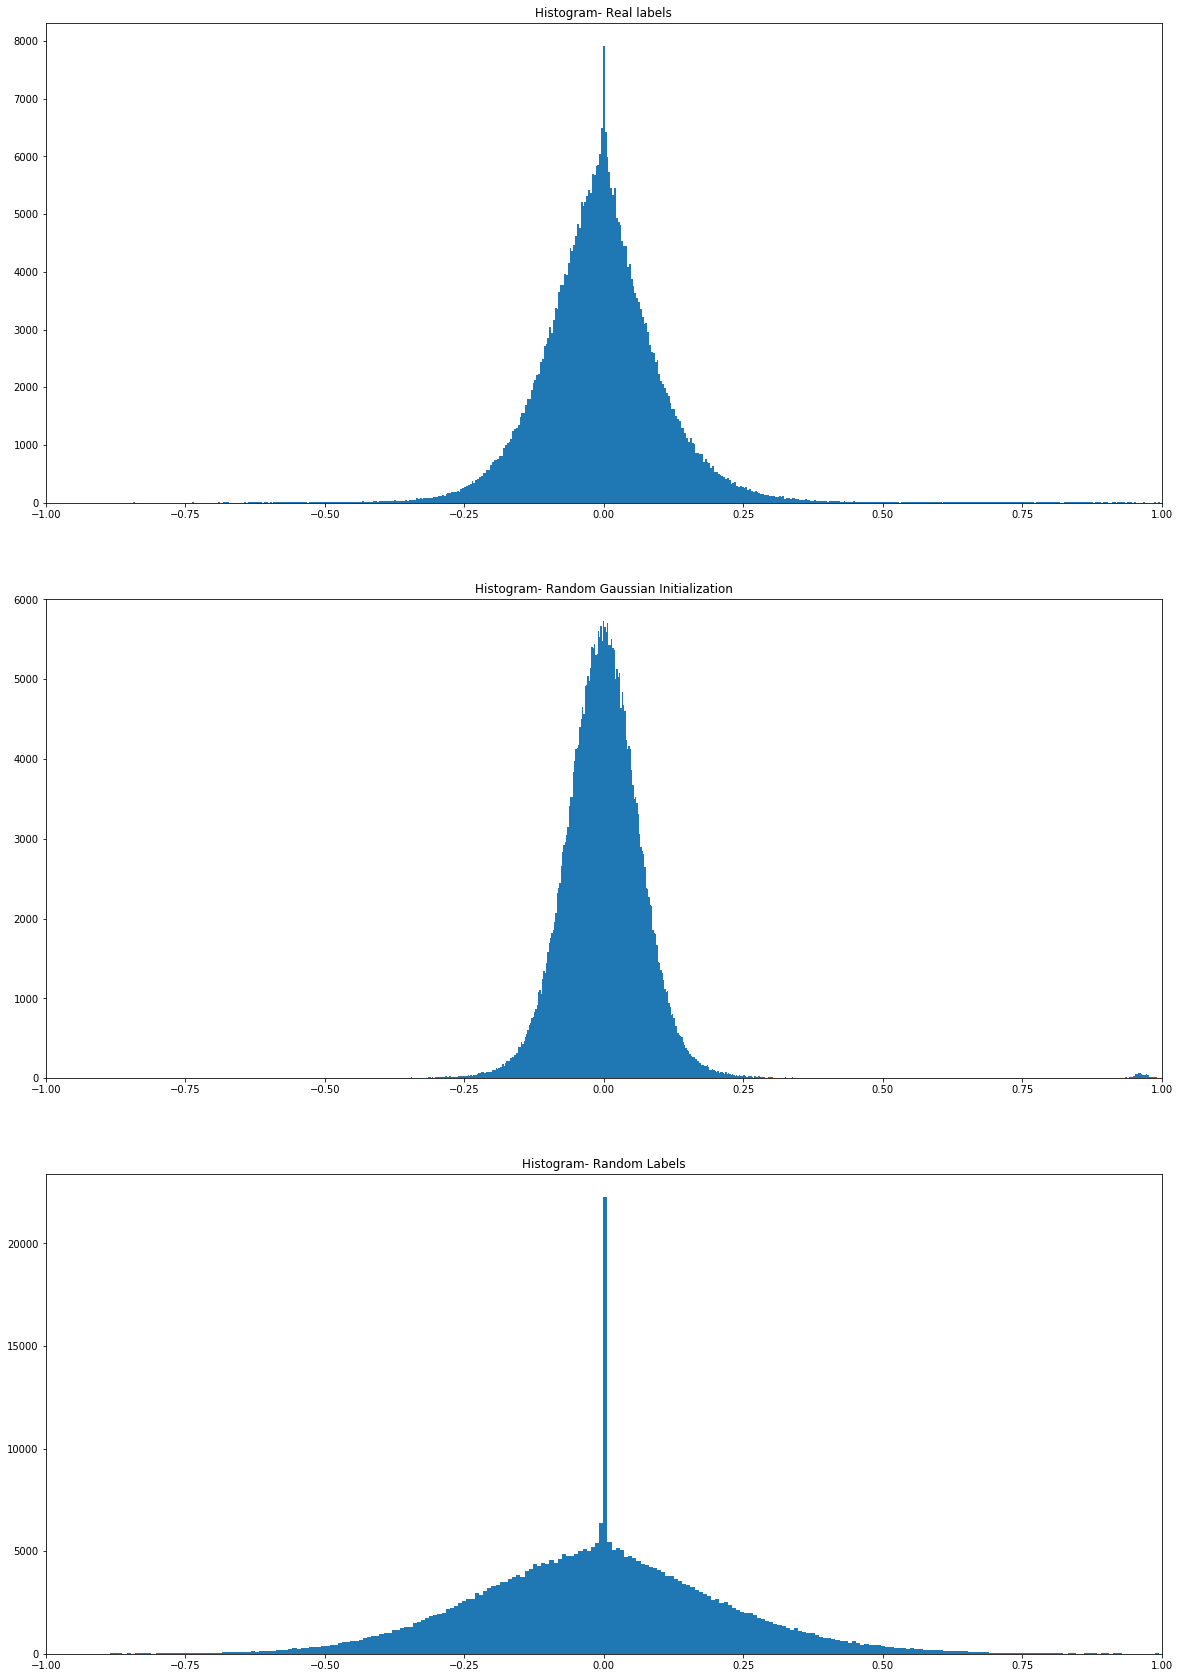

In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams
def extract_model_parameters_to_array(model):
    parameters_array = np.array([])
    for name, param in model.named_parameters():
        if param.requires_grad:
            flattened_param = param.data.numpy().flatten()
            parameters_array = np.append(parameters_array, flattened_param)
    return parameters_array

# Convert from torch to numpy array
parameters_real_labels    =  extract_model_parameters_to_array(model_real_labels)
parameters_gaussain_init=  extract_model_parameters_to_array(model_gaussain_init)
parameters_random_labels  =  extract_model_parameters_to_array(model_random_labels) 

# Round to 4 decim
parameters_real_labels   = parameters_real_labels.round(decimals=4)
parameters_gaussain_init = parameters_gaussain_init.round(decimals=4)
parameters_random_labels = parameters_random_labels.round(decimals=4)

# Plot histogram of the weights
rcParams['figure.figsize'] = 20, 30
plt.subplot(3,1,1)
plt.hist(parameters_real_labels, bins='auto')
plt.title("Histogram- Real labels")
axes = plt.gca()
axes.set_xlim([-1,1])
plt.subplot(3,1,2)
plt.hist(parameters_gaussain_init, bins='auto')
plt.title("Histogram- Random Gaussian Initialization")
axes = plt.gca()
axes.set_xlim([-1,1])
plt.subplot(3,1,3)
plt.hist(parameters_random_labels, bins='auto')
plt.title("Histogram- Random Labels")
axes = plt.gca()
axes.set_xlim([-1,1])
plt.show()

In [5]:
def entropy(X):
    probs = [np.mean(X == c) for c in set(X)]
    return np.sum(-p * np.log2(p) for p in probs)

# Compute the entorpy for each setss of weights
start_time = time.time()
entropy_real_labels = entropy(parameters_real_labels)
print('Entropy real labels = %f, time=%f [sec]' % (entropy_real_labels, time.time() - start_time ))
start_time = time.time()
entropy_gaussain_init = entropy(parameters_gaussain_init)
print('Entropy Gaussain init = %f, time=%f [sec]' % (entropy_gaussain_init, time.time() - start_time ))
start_time = time.time()
entropy_random_labels = entropy(parameters_random_labels)
print('Entropy random labels = %f, time=%f [sec]' % (entropy_random_labels, time.time() - start_time ))

Entropy real labels = 12.026414, time=3.894071 [sec]
Entropy Gaussain init = 11.445055, time=2.651726 [sec]
Entropy random labels = 12.943937, time=6.550553 [sec]
